In [1]:
from pylab import *
import matplotlib.pyplot as plt
import sqlite3 
import pandas as pd
import numpy as np
import random
import math
import xlsxwriter
test_schedule = pd.read_excel(
    'LichThi_L2_HK2_NH2019.xlsx', 
    sheet_name='Sheet1',
    header=0,
    skiprows=7,
    usecols=["STT", "Tên MH","Ngày thi","Ca Thi","Phòng Thi","Số CBCT"],
    nrows=612)


In [2]:
test_schedule=test_schedule.rename(columns = {'STT':'CourseID','Tên MH':'CourseName','Ngày thi':'TestDate','Ca Thi':'ShiftOD','Phòng Thi':'Room','Số CBCT':'QuantityOfInvigilator',})
test_schedule.sort_values(by=['TestDate','ShiftOD'], inplace=True, ascending=True)


In [3]:
db_conn = sqlite3.connect("assignment1.db")
cursor = db_conn.cursor()

In [4]:
cursor.executescript(""" 
    CREATE TABLE test_schedule(
        CourseID INTEGER NOT NULL,
        CourseName TEXT,
        TestDate Date, 
        ShiftOD INTEGER,
        Room TEXT,
        QuantityOfInvigilator INTEGER,
        PRIMARY KEY(CourseID)
        ); 
    """)

In [5]:
test_schedule.to_sql('test_schedule', db_conn, if_exists='append', index=False)

In [6]:
convert_ShiftOD=pd.read_sql("SELECT * FROM test_schedule", db_conn)
convert_ShiftOD=convert_ShiftOD.groupby(['TestDate','ShiftOD'])['QuantityOfInvigilator'].sum().reset_index(name='totalOfInvigilator')
df=convert_ShiftOD[['TestDate', 'ShiftOD']]
TestDate=convert_ShiftOD['TestDate'].drop_duplicates().reset_index()
TestDate=TestDate['TestDate']
for n in range(1,5):
    for i in TestDate:
        df1 = [i, n]
        rr=(df == df1).all(1).any()
        if rr == False:
            df1 = pd.DataFrame([[i, n, 0]],
                       columns=['TestDate','ShiftOD','totalOfInvigilator'])
            convert_ShiftOD=pd.concat([df1, convert_ShiftOD],ignore_index=True)

In [7]:
convert_ShiftOD = convert_ShiftOD.sort_values(['TestDate','ShiftOD'], ascending=True, ignore_index=True)
convert_ShiftOD['new_ShiftOD'] = range(1, len(convert_ShiftOD) + 1)


In [8]:
cursor.executescript(""" 
    CREATE TABLE convert_ShiftOD(
        TestDate INTEGER NOT NULL,
        ShiftOD INTEGER,
        totalOfInvigilator INTEGER,
        new_ShiftOD INTEGER,
        CONSTRAINT fk_date
        FOREIGN KEY (TestDate, ShiftOD)
        REFERENCES test_schedule(TestDate, ShiftOD)
        ); 
    """)

In [9]:
convert_ShiftOD.to_sql('convert_ShiftOD', db_conn, if_exists='append', index=False)

In [10]:
new_ShiftofDay=pd.read_sql("""SELECT test_schedule.CourseID, convert_ShiftOD.new_ShiftOD, test_schedule.QuantityOfInvigilator 
            FROM test_schedule, convert_ShiftOD 
            WHERE test_schedule.TestDate=convert_ShiftOD.TestDate AND test_schedule.ShiftOD=convert_ShiftOD.ShiftOD""", db_conn)

In [11]:
invigilator = pd.read_excel(
    'TeacherList.xlsx', 
    sheet_name='Sheet1',
    header=0,
    )

In [12]:
cursor.executescript(""" 
    CREATE TABLE invigilator(
        ID INT,
        Full_Name TEXT,
        PRIMARY KEY(ID)
        ); 
    """)

In [13]:
invigilator.to_sql('invigilator', db_conn, if_exists='append', index=False)

In [14]:
number_of_supervisors_shift = [] # mảng lưu số lượng người coi thi của mỗi ca
for i in range(0,len(convert_ShiftOD)):
    number_of_supervisors_shift.append(convert_ShiftOD.iat[i,2])

In [15]:
cases_without_supervision = [] # mảng lưu những ca thi không cần người coi
for i in range(0,len(convert_ShiftOD)):
    if convert_ShiftOD.iat[i,2]==0:
        cases_without_supervision.append(convert_ShiftOD.iat[i,3])
cases_without_supervision

[4, 8, 12, 16, 20, 23, 24, 28, 32, 36, 40, 44, 48]

In [16]:
n_invigilators = invigilator['ID'].value_counts().count()         #tổng số CBCT a

shifts_count = convert_ShiftOD['new_ShiftOD'].value_counts().count()      #đém số ca thi b

total_shifts = convert_ShiftOD['totalOfInvigilator'].sum(axis=0)              #tong so ca thi can coi c
 
average_shifts = total_shifts//n_invigilators                 # so ca thi trung binh mot Can Bo Coi Thi can coi d

f=total_shifts%n_invigilators                   # so CBCT coi nhieu hon trung binh f

n_individuals=50                                       #   số lượng cá thể trong quần thể

In [17]:
def arrange_supplies(arr):                         # tạo một cá thể
    k=0
    for i in range(0, n_invigilators):
        sum=0
        for j in range(0, shifts_count):
            if k<f :                   #f=c%a
                 if sum<average_shifts+1 :
                    arr[0][i][j]=1
                    sum=sum+arr[0][i][j]
            else :
                if sum<average_shifts :
                    arr[0][i][j]=1
                    sum=sum+arr[0][i][j]
        random.shuffle(arr[0][i])
        k=k+1
    return arr  

In [18]:
def create_individual():       #sắp xếp lại thành cá thể hoàn chỉnh
    arr = np.zeros((1,n_invigilators,shifts_count),dtype = int) # tạo mảng zero
    arrange_supplies(arr)                     # tạo mảng 
    drr=arr[0].sum(axis=0)            #tạo mảng chứa tổng mỗi cột của arr[]
    brr = []
    for i in range(len(convert_ShiftOD)):
        brr.append( drr[i]-number_of_supervisors_shift[i])      #tạo mảng chứa 
    for i in range(0,len(brr)):
        while brr[i]<0:
            temp=0
            for m in range(0,shifts_count):
                if brr[m]>0:
                    for j in range(0,n_invigilators):
                        if arr[0][j][i]==0 and arr[0][j][m]==1:
                                arr[0][j][i], arr[0][j][m] = arr[0][j][m], arr[0][j][i]
                                brr[m]= brr[m]-1
                                brr[i]= brr[i]+1
                                temp=1
                                break
            if temp==0:
                for m in range(0,shifts_count):
                    if brr[m]>0:
                         for j in range(0,n_invigilators):
                            if arr[0][j][m]==1:
                                arr[0][j][m]=0
                                brr[m]= brr[m]-1
                                break
                for j in range(n_invigilators-1,0,-1):
                    if arr[0][j][i]==0 :
                                arr[0][j][i]=1
                                brr[i]= brr[i]+1
                                break
    return arr

In [19]:
def create_population():
    population = np.zeros((0,n_invigilators,shifts_count),dtype = int)   #   khởi tạo quần thể ban đầu
    for i in range(0,n_individuals):
        arr = create_individual()
        population  = np.concatenate((population ,arr))
    return population

In [20]:
population=create_population()

In [21]:
population[11].sum(axis=0)

array([ 29, 115,  14,   0,  15, 104,  15,   0,  14, 108,  23,   0,  14,
        92,  22,   0,  27,  52,  20,   0,  43,  39,   0,   0,  14,  53,
        32,   0,  12,  73,  30,   0,   7,  47,  32,   0,  16,  49,  38,
         0,  20,  34,  36,   0,  30,  38,   2,   0])

In [22]:
def weight_compute(bin_matrix, pen_val=10):
    """
    Compute weight overall weight on input binary matrix
    arguments:
    - bin_matrix (numpy array): binary matrix with shape num_of_staff x num_of_exam
    - pen_value: the penalty value for each day longer than expected
    return:
    overall weight: type int
    """
    # compute the number of "1" value on each row
    num_of_ones = np.sum(bin_matrix, axis=1) 
    # compute number of day expected from exam assignment
    actual_days = list(map(lambda x: math.ceil(x), num_of_ones/4))
    #print(actual_days)
    # Find the position of 1 value on each row
    one_pos = np.where(bin_matrix == 1)[1]
    #print(one_pos[11:23])
    # Compute temporary indices for reshaping one_pos
    adj_indices = [0]
    sum_temp = 0
    for i in range(0, len(num_of_ones)):
        sum_temp = sum_temp + num_of_ones[i]
        adj_indices.append(sum_temp)
    for i in range(1, len(adj_indices)):
        if adj_indices[i]==adj_indices[i-1]:
            return 20000
    #print(adj_indices)
    # Reshaping one_pos to array with len=num_of_staff and each element is 
    # an array store index of 1  value 
    shaped_one_pos = [ one_pos[adj_indices[i]:adj_indices[i+1]] for i in range(0, len(adj_indices)-1)]
    #print(shaped_one_pos)
    # Find min and max position of 1 value on each staff
    min_pos = list(map(min, shaped_one_pos))
    #print(min_pos)
    max_pos = list(map(max, shaped_one_pos))
    #print(max_pos)
    #Compute number of unattended shifts between max and min
    unattended_shifts=[]
    for i,j in zip(min_pos,max_pos):
        unattended_shifts.append(len([x for x in cases_without_supervision if i<x<j]))
    # Compute number of maximum 1 value could have between min_pos and max_pos for each staff
    exp_ones = [ max-min+1-i for min, max, i in zip(min_pos, max_pos, unattended_shifts)]
    # Compute number of 0 value between min_pos and max_pos 
    num_of_zero = [m_one - n_one for m_one, n_one in zip(exp_ones, num_of_ones)]
    # Compute number of days current spaned on each staff
    day_spans = [math.ceil((max+1)/4) - min//4 for min, max in zip(min_pos, max_pos)]
    #print(day_spans)
    # Compute number of days for penalizing 
    day_pens = [c_day - a_day for c_day, a_day in zip(day_spans, actual_days)]
    #print(day_pens)
    # compute overall weight
    weight = sum(num_of_zero) + sum(day_pens)*pen_val
    return weight

In [23]:
individual_copy=population[11].copy()
for i in cases_without_supervision:
    individual_copy[:,i-1]=1   

In [24]:
weight_compute(population[11])

11523

In [25]:
def kiem_tra(individual1):         #    hàm kiểm tra các ca thi có khớp nhau hay không
    temp=(np.array(individual1) == np.array(number_of_supervisors_shift))
    for i in temp:
        if i==False:
            return False
            break

In [26]:
# tinh fitness
def compute_fitness(individual):
    fitness=0
    tong_coithi= individual.sum()               #  tổng số buổi coi thi trong kì thi 
    fitness=weight_compute(individual)
    if tong_coithi != total_shifts:                        #  nếu ràng buộc cứng bị vi phạm thì phạt nặng
        fitness=fitness+20000
    if kiem_tra(individual.sum(axis=0))==False:
        fitness=fitness+20000
    return fitness

In [27]:
# chon loc
def selection(sorted_population):
    index1 = random.randint(0, n_individuals-1)
    while True:
        index2 = random.randint(0, n_individuals-1)
        if index2 != index1:
            break
    individual = sorted_population[index1]
    if index2 > index1:
        individual = sorted_population[index2]
    return individual

In [28]:
# lai ghep:
def crossover(individual1, individual2, crossover_rate = 0.5):
    individual1_new = np.zeros((1,n_invigilators,shifts_count),dtype = int)
    individual2_new = np.zeros((1,n_invigilators,shifts_count),dtype = int)
    individual1_new[0] = individual1.copy()
    individual2_new[0] = individual2.copy()
    for i in range(0, n_invigilators):
        for j in range(0, shifts_count):
            if random.random() < crossover_rate:
                individual1_new[0][i][j] = individual2[i][j]
                individual2_new[0][i][j] = individual1[i][j]            
    return individual1_new, individual2_new

In [29]:
# dot bien
def mutate(individual, mutation_rate = 0.05):
    individual_m = np.zeros((1,n_invigilators,shifts_count),dtype = int)
    individual_m = individual.copy()
    for i in range(0, n_invigilators):
        for j in range(0, shifts_count):
            if random.random() < mutation_rate:
                individual_m[0][i][j] = random.randint(0,1)
    return individual_m

In [30]:
# tao quan the moi
fitnesses = []
def create_new_population(sorted_old_population):
    # luu vao losses
    fitnesses.append(compute_fitness(sorted_old_population[-1]))
    
    #in cac gia tri tot nhat qua tung doi
    print(fitnesses[-1])
    #print(sorted_old_population[-1])
    new_population =  np.zeros((0,n_invigilators,shifts_count),dtype = int)
    while len(new_population) < n_individuals-10:
        # chon loc
        individual1 = selection(sorted_old_population)
        individual2 = selection(sorted_old_population)
        # lai ghep
        individual_c1, individual_c2 = crossover(individual1, individual2)
        # dot bien
        individual_m1 = mutate(individual_c1)
        individual_m2 = mutate(individual_c2) 
        # nếu không thỏa mãn ràng buộc cứng thay bằng cá thể mới
        if compute_fitness(individual_m1[0])>15000:                     
            individual_m1 = create_individual() 
        if compute_fitness(individual_m2[0])>1000:
            individual_m2 = create_individual()
        # cho vao quan the moi
        new_population = np.concatenate((new_population ,individual_m1))
        new_population = np.concatenate((new_population ,individual_m2))
    # cho 10 con dep nhat cua quan the cu vao quan the moi
    for i in range(1,11):
        new_individual =  np.zeros((1,n_invigilators,shifts_count),dtype = int)
        new_individual[0] = sorted_old_population[-i].copy()
        new_population = np.concatenate((new_population ,new_individual))
    return new_population

In [31]:
def compute_pen(bin_matrix):
    """
    Compute weight overall weight on input binary matrix
    arguments:
    - bin_matrix (numpy array): binary matrix with shape num_of_staff x num_of_exam
    - pen_value: the penalty value for each day longer than expected
    return:
    overall weight: type int
    """
    # compute the number of "1" value on each row
    num_of_ones = np.sum(bin_matrix, axis=1) 
    # compute number of day expected from exam assignment
    actual_days = list(map(lambda x: math.ceil(x), num_of_ones/4))
    #print(actual_days)
    # Find the position of 1 value on each row
    one_pos = np.where(bin_matrix == 1)[1]
    #print(one_pos[11:23])
    # Compute temporary indices for reshaping one_pos
    adj_indices = [0]
    sum_temp = 0
    for i in range(0, len(num_of_ones)):
        sum_temp = sum_temp + num_of_ones[i]
        adj_indices.append(sum_temp)
    for i in range(1, len(adj_indices)):
        if adj_indices[i]==adj_indices[i-1]:
            return 20000
    #print(adj_indices)
    # Reshaping one_pos to array with len=num_of_staff and each element is 
    # an array store index of 1  value 
    shaped_one_pos = [ one_pos[adj_indices[i]:adj_indices[i+1]] for i in range(0, len(adj_indices)-1)]
    #print(shaped_one_pos)
    # Find min and max position of 1 value on each staff
    min_pos = list(map(min, shaped_one_pos))
    #print(min_pos)
    max_pos = list(map(max, shaped_one_pos))
    #print(max_pos)
    #Compute number of unattended shifts between max and min
    unattended_shifts=[]
    for i,j in zip(min_pos,max_pos):
        unattended_shifts.append(len([x for x in cases_without_supervision if i<x<j]))
    # Compute number of maximum 1 value could have between min_pos and max_pos for each staff
    exp_ones = [ max-min+1-i for min, max, i in zip(min_pos, max_pos, unattended_shifts)]
    # Compute number of 0 value between min_pos and max_pos 
    num_of_zero = [m_one - n_one for m_one, n_one in zip(exp_ones, num_of_ones)]
    num_of_zero_matrix.append(sum(num_of_zero))
    # Compute number of days current spaned on each staff
    day_spans = [math.ceil((max+1)/4) - min//4 for min, max in zip(min_pos, max_pos)]
    # Compute number of days for penalizing 
    day_pens = [c_day - a_day for c_day, a_day in zip(day_spans, actual_days)]
    day_pens_matrix.append(sum(day_pens)*10)
    #print(day_pens)
    # compute overall weight

In [32]:
#### tao quan the ban dau
population=create_population()
n_generations = 1000
num_of_zero_matrix=[]
day_pens_matrix=[]
fit_matrix=[]
genera_matrix=[]
for i in range(n_generations):
    sorted_old_population = sorted(population, reverse=True, key = compute_fitness)
    fit_matrix.append((-1)*compute_fitness(sorted_old_population[-1]))
    compute_pen(sorted_old_population[-1])
    genera_matrix.append(i)
    population = create_new_population(sorted_old_population)

11504
11504
11504
11464
11464
11413
11413
11413
11413
11413
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11401
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
11343
1134

In [33]:
sorted_old_population[4]

array([[0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0]])

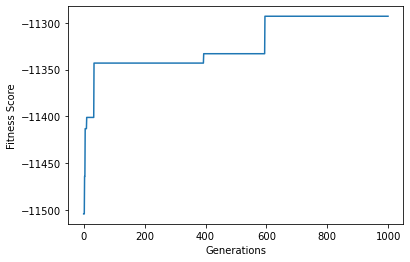

In [34]:
plt.plot(genera_matrix, fit_matrix)
plt.xlabel('Generations')
plt.ylabel('Fitness Score')
plt.show()


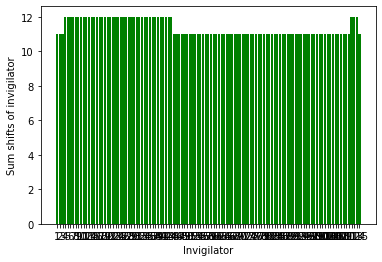

In [35]:
sum_col=sorted_old_population[-1].sum(axis=1)
sum_shifts= []
invigilator=[]
for i in range(0,len(sorted_old_population[-1])):
    sum_shifts.append(sum_col[i])
    invigilator.append(str(i+1))
plt.bar(invigilator,sum_shifts, color='green')
plt.xlabel("Invigilator")
plt.ylabel("Sum shifts of invigilator")
plt.show()

In [52]:
fit_matrix[500]

-11333

In [36]:
# hien thi tuyen duong ngan nhat
print('duong di ngan nhat: ', 'chi phi: ', fitnesses[-1])
print(sorted_old_population[49])
#11340
#11310
#11277
#11275

duong di ngan nhat:  chi phi:  11293
[[0 1 0 ... 1 0 0]
 [1 1 0 ... 1 1 0]
 [0 1 0 ... 1 0 0]
 ...
 [0 1 1 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]]


In [37]:
weight_compute(sorted_old_population[-1])

11293

In [38]:
workbook = xlsxwriter.Workbook('temp.xlsx')
worksheet = workbook.add_worksheet()
row = 0
for i in range(len(sorted_old_population[-1].T)):
    worksheet.write(row, i, "Ca Thi " + str(i + 1))
row += 1
for col, data in enumerate(sorted_old_population[-1].T):
    worksheet.write_column(row, col, data)
workbook.close()

In [39]:
new_ShiftofDay1=new_ShiftofDay.copy()
new_ShiftofDay

,CourseID,new_ShiftOD,QuantityOfInvigilator
0,1,46,3
1,2,46,2
2,3,46,2
3,4,15,2
4,5,25,2
...,...,...,...
607,608,31,3
608,609,31,3
609,610,31,3
610,611,22,2


In [40]:
invigilatorID = []
CourseID = []
for i in range(len(sorted_old_population[-1])):
    for j in range(len(sorted_old_population[-1][0])):
        if sorted_old_population[-1][i][j] == 1:
            invigilatorID.append(i + 1)
            for p in range(len(new_ShiftofDay1)):
                if (new_ShiftofDay1.iat[p, 1] == j + 1) and (new_ShiftofDay1.iat[p, 2] > 0):
                    CourseID.append(p + 1)
                    new_ShiftofDay1.iat[p, 2] = new_ShiftofDay1.iat[p, 2] - 1
                    break

In [41]:
data = {'ID': invigilatorID, 
        'CourseID':CourseID} 

In [42]:
assign_df = pd.DataFrame(data)
cursor.executescript("""
                        drop table if exists assign_db;
                        create table if not exists assign_db(
                        ID Integer,
                        CourseID Integer,
                        FOREIGN KEY(ID) REFERENCES invigilator_db(ID),
                        FOREIGN KEY(CourseID) REFERENCES schedule_db(CourseID)
                        );""")
assign_df.to_sql('assign_db', db_conn, if_exists='append', index=False)
scheduler_df = pd.read_sql("""SELECT assign_db.CourseID,  test_schedule.CourseName, test_schedule.Room, test_schedule.ShiftOD, test_schedule.TestDate, test_schedule.QuantityOfInvigilator, GROUP_CONCAT(invigilator.Full_Name) Invigilator
    FROM assign_db, invigilator, test_schedule
    WHERE assign_db.ID=invigilator.ID and test_schedule.CourseID = assign_db.CourseID
    GROUP BY assign_db.CourseID
    ORDER BY assign_db.CourseID;""", db_conn)

In [43]:
ab=pd.read_sql("""SELECT invigilator.ID, Count( Distinct test_schedule.TestDate)
FROM assign_db, invigilator, test_schedule
WHERE assign_db.ID=invigilator.ID and test_schedule.CourseID = assign_db.CourseID
Group By invigilator.ID
ORDER BY invigilator.ID""",db_conn)
ab

,ID,Count( Distinct test_schedule.TestDate)
0,1,7
1,2,7
2,3,9
3,4,9
4,5,9
...,...,...
110,111,9
111,112,8
112,113,9
113,114,7


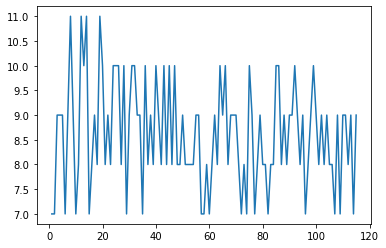

In [44]:
id1=[]
array1=[]
for i in range(len(ab)):
    array1.append(ab.iat[i,1])
    id1.append(ab.iat[i,0])
plt.plot(id1, array1)
plt.show()

In [45]:
cursor.executescript(""" 
    Drop TABLE test_schedule;
    Drop TABLE convert_ShiftOD;
    Drop TABLE invigilator;
    Drop TABLE new_ShiftofDay;
    Drop TABLE assign_schedule;
    Drop TABLE Offical_assign_schedule
    """) 

OperationalError: no such table: new_ShiftofDay

In [ ]:
cursor.executescript(""" 

    Drop TABLE Offical_assign_schedule
    """) 